In [2]:
import numpy as np
import tensorflow as tf
import sunpy.map
import os
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
import matplotlib.pyplot as plt
import datetime
import time
import IPython.display as display

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 这一行注释掉就是使用gpu，不注释就是使用cpu

用GPU版本更容易爆内存，不明白为什么

In [4]:
PATH = r'E:\Program Files\VSCode\2021_ImagingWithDeepLearning\my_test_data'
SHAPE = [256, 256, 1]
Scaler_aia = Rescaling(scale=1.0 / 17000)
Scaler_hmi = Rescaling(scale=1.0 / 76000)
Cropper = CenterCrop(height=256, width=256)

## Data loading

In [5]:
def LoadOnePair():
    fits_aia = r'E:\\Program Files\\VSCode\\2021_ImagingWithDeepLearning\\my_test_data_1\\1\\aia.lev1_uv_24s.2012-07-05T032007Z.1700.image_lev1.fits'
    fits_hmi = r'E:\\Program Files\\VSCode\\2021_ImagingWithDeepLearning\\my_test_data_2\\2\\hmi.Ic_45s.20120705_032015_TAI.2.continuum.fits'
    map_aia = sunpy.map.Map(fits_aia)
    data_aia = map_aia.data
    data_aia[np.where(data_aia < 10)] = 0
    data_aia = Scaler_aia(data_aia)

    map_hmi = sunpy.map.Map(fits_hmi)
    data_hmi = map_hmi.data
    data_hmi[np.where(np.isnan(data_hmi))] = 0
    data_hmi = Scaler_hmi(data_hmi)
    return data_aia, data_hmi

In [6]:
# Make a train dataset.
examples = []
labels = []
for root, dirs, files in os.walk(os.path.join(PATH, '1')):
    for file in files:
        path_file = os.path.join(root, file)
        map = sunpy.map.Map(path_file)
        data = map.data
        exptime = map.exposure_time.value
        data = data / exptime
        data[np.where(data < 10)] = 0
        # substitute small and negative amount with 0 for aia
        data = Scaler_aia(data)
        data = tf.expand_dims(data, 2)
        data = tf.expand_dims(data, 0)
        data = Cropper(data)
        examples.append(data)
for root, dirs, files in os.walk(os.path.join(PATH, '2')):
    for file in files:
        path_file = os.path.join(root, file)
        map = sunpy.map.Map(path_file)
        data = map.data
        data[np.where(np.isnan(data))] = 0
        # substitute 'nan' with 0 for hmi
        data = Scaler_hmi(data)
        data = tf.expand_dims(data, 2) # Add the fourth dimension, the color domension
        data = tf.expand_dims(data, 0) # Add the first dimension, the batch dimension
        data = Cropper(data)
        labels.append(data)
train_dataset = tf.data.Dataset.from_tensor_slices((examples, labels))

In [39]:
# Make a test dataset.
examples = []
labels = []
for root, dirs, files in os.walk(os.path.join(PATH, '3')):
    for file in files:
        path_file = os.path.join(root, file)
        map = sunpy.map.Map(path_file)
        data = map.data
        data[np.where(data < 10)] = 0
        # substitute small and negative amount with 0 for aia
        data = Scaler_aia(data)
        data = tf.expand_dims(data, 2)
        data = tf.expand_dims(data, 0)
        data = Cropper(data)
        examples.append(data)
for root, dirs, files in os.walk(os.path.join(PATH, '4')):
    for file in files:
        path_file = os.path.join(root, file)
        map = sunpy.map.Map(path_file)
        data = map.data
        data[np.where(np.isnan(data))] = 0
        # substitute 'nan' with 0 for hmi
        data = Scaler_hmi(data)
        data = tf.expand_dims(data, 2)
        data = tf.expand_dims(data, 0)
        data = Cropper(data)
        data = np.transpose(data)
        labels.append(data)
test_dataset = tf.data.Dataset.from_tensor_slices((examples, labels))

In [8]:
# inp, re = next(iter(train_dataset))
# print(inp.shape)

In [9]:
# inp, re = LoadOnePair() # load one single data set for test.
# inp = tf.expand_dims(inp, 2)
# inp = tf.expand_dims(inp, 0)
# print(inp.shape)

## Building models(generator)

The generator of your pix2pix cGAN is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the Image segmentation tutorial and on the U-Net project website.)

1. Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
2. Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
3. There are skip connections between the encoder and decoder (as in the U-Net).

In [10]:
OUTPUT_CHANNELS = 1

In [11]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [12]:
# down_model = downsample(filters=3, size=4)
# down_result = down_model(inp)
# print (down_result.shape)

In [13]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [14]:
# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print(up_result.shape)

In [15]:
def Generator():
  inputs = tf.keras.layers.Input(shape=SHAPE)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

我先看看他这个能不能直接用。不行再试试用韩国人的这波，他们是各自多加了两层。

In [16]:
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [17]:
# gen_output = generator(inp, training=False)

In [18]:
# print(gen_output.shape)
# print(np.max(gen_output[0]))
# print(np.min(gen_output[0]))

**This here reminds me that we can actually learn all of the wave lengths together, just add up the tensor, i.e. make a tensor with shape (4096, 4096, 9), combining all of the wavelengths of aia!**

In [19]:
# plt.imshow(gen_output[0], cmap='gray')
# plt.colorbar()
# plt.show()

## Define the generator loss

"
GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the pix2pix paper.

1. The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
2. The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
3. This allows the generated image to become structurally similar to the target image.
4. The formula to calculate the total generator loss is gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.
"

BTW this is also the loss function the Korean team used. I say there is no need to change here.

In [20]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image patch is real or not real, as described in the pix2pix paper.

1. Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
2. The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
3. Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image.
4. The discriminator receives 2 inputs:
    1. The input image and the target image, which it should classify as real.
    2. The input image and the generated image (the output of the generator), which it should classify as fake.
    3. Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

In [22]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=SHAPE, name='input_image')
  tar = tf.keras.layers.Input(shape=SHAPE, name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [23]:
discriminator = Discriminator()

In [24]:
# disc_out = discriminator([inp, gen_output], training=False)
# plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
# plt.colorbar()

## Define the discriminator loss

`discriminator_loss` takes 2 inputs real images and generated images and returns a `total_loss` as the sum of `real_loss` and `generated_loss`. `real_loss` is a sigmoid cross-entropy loss of the real images and an array of ones. `generated_loss` is a sigmoid cross-entropy loss of the generated images and an array of zeros.

In [25]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Define the optimizers and a checkpoint-saver

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

plot some images during training.

In [28]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

## Training

1. For each example input generates an output.
2. The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
3. Next, calculate the generator and the discriminator loss.
4. Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
5. Finally, log the losses to TensorBoard.

In [29]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [30]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [31]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      start = time.time()
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start} sec\n')

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard:

In [32]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

In [33]:
# fit(train_dataset, test_dataset, steps=40000)

## Restore the latest checkpoint and test the network

In [34]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

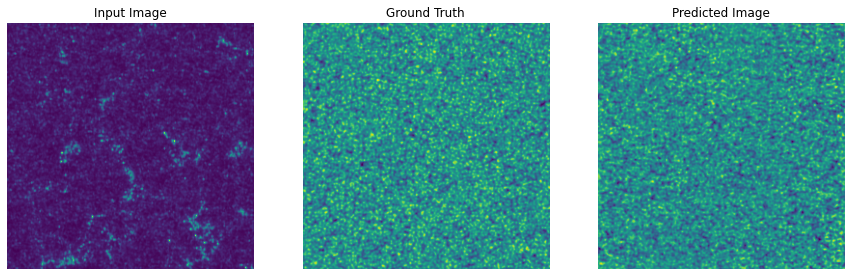

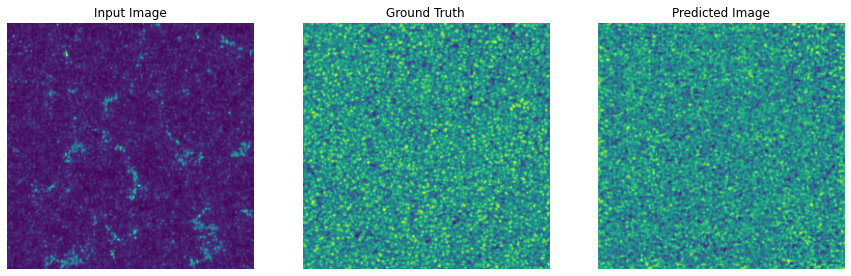

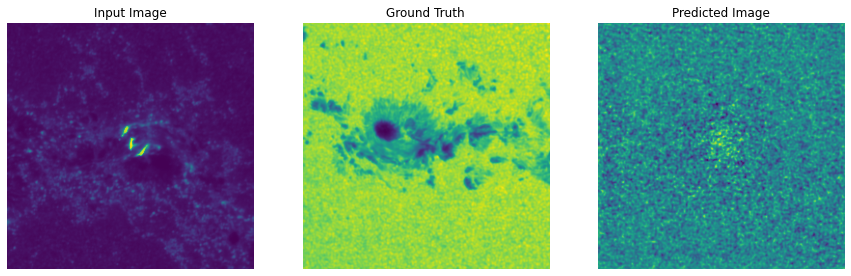

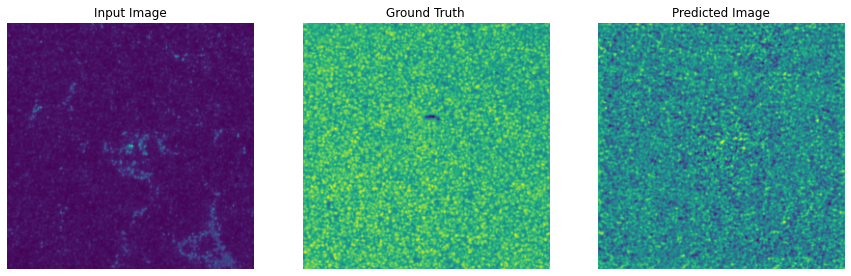

In [41]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(4):
  generate_images(generator, inp, tar)